<h1>Empleamos el ONI</h1>

In [1]:
# import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np
# from tools import search_oni
# import skimage
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
# from tools import filt_anom2

In [3]:
# Load data
data_oni = pd.read_csv('E:\Proyecto de Grado\Data\ONI_NOAA - copia.txt', sep="\s+")

# Create new columns
data_oni['TIME'] = pd.to_datetime(
    dict(year=data_oni["YR"], month=data_oni["MON"], day=1), format='%Y-%m')
data_oni['category'] = data_oni['ANOM'].apply(
    lambda x: 'Niño' if x >= 0.5 else 'Neutro' if x > -0.5 else 'Niña')

# Column to classify data by month and category
data_oni["month_anomaly"] = data_oni["MON"].astype(
    "str") + " " + data_oni["category"]

data_oni

,YR,MON,TOTAL,ClimAdjust,ANOM,TIME,category,month_anomaly
0,1993,1,26.70,26.59,0.10,1993-01-01,Neutro,1 Neutro
1,1993,2,27.17,26.79,0.38,1993-02-01,Neutro,2 Neutro
2,1993,3,27.68,27.28,0.40,1993-03-01,Neutro,3 Neutro
3,1993,4,28.41,27.70,0.71,1993-04-01,Niño,4 Niño
4,1993,5,28.71,27.80,0.91,1993-05-01,Niño,5 Niño
...,...,...,...,...,...,...,...,...
331,2020,8,26.27,26.86,-0.59,2020-08-01,Niña,8 Niña
332,2020,9,25.89,26.72,-0.83,2020-09-01,Niña,9 Niña
333,2020,10,25.46,26.72,-1.25,2020-10-01,Niña,10 Niña
334,2020,11,25.28,26.70,-1.42,2020-11-01,Niña,11 Niña


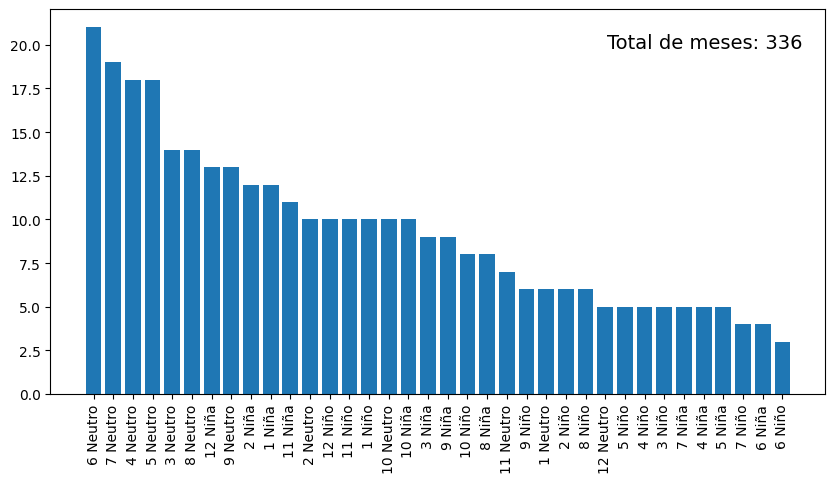

In [3]:
# Plot to show the number of months by category and its occurrence
counts = data_oni["month_anomaly"].value_counts()

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(counts.index, counts.values)
ax.text(0.97, 0.90, "Total de meses: " + str(len(data_oni)),
        transform=ax.transAxes, fontsize=14, ha="right")

plt.xticks(rotation=90)

plt.show()

In [4]:
# Load NetCDF file
ds_currents = xr.open_dataset(
    "E:\Proyecto de Grado\Data\corrientes_u_v_5m_enero1993_diciembre2020.nc")
ds_currents = ds_currents.mean(dim="depth")

# Extract original coordinates
lat = ds_currents.latitude.values
lon = ds_currents.longitude.values
time = ds_currents.time.values

# Extract variables
vo = ds_currents.vo.values
uo = ds_currents.uo.values

ds_currents

<xarray.Dataset>
Dimensions:    (latitude: 205, time: 336, longitude: 372)
Coordinates:
  * latitude   (latitude) float32 7.0 7.083 7.167 7.25 ... 23.83 23.92 24.0
  * time       (time) datetime64[ns] 1993-01-16T12:00:00 ... 2020-12-16T12:00:00
  * longitude  (longitude) float32 -89.92 -89.83 -89.75 ... -59.17 -59.08 -59.0
Data variables:
    vo         (time, latitude, longitude) float32 0.03101 0.06458 ... 0.04016
    uo         (time, latitude, longitude) float32 0.07703 0.08228 ... 0.06006

In [7]:
# Create dataset with month and anomaly classification as coordinates
month_anomaly_currents = xr.Dataset(
    data_vars={
        "vo": (["month_anomaly", "lat", "lon"], vo),
        "uo": (["month_anomaly", "lat", "lon"], uo),
    },
    coords={
        "month_anomaly": data_oni["month_anomaly"].values, "lat": lat, "lon": lon
    }
).groupby("month_anomaly").mean()  # Group by month and anomaly classification

# Save NwetCDF file
month_anomaly_currents.to_netcdf(
    r"E:\Proyecto de Grado\Data\Nueva carpeta\corrientes_month_anomaly.nc")

In [6]:
# Create dataset with anomaly classification as coordinates
anomaly_currents = xr.Dataset(
    data_vars={
        "vo": (["anomaly", "lat", "lon"], vo),
        "uo": (["anomaly", "lat", "lon"], uo),
    },
    coords={
        "anomaly": data_oni["category"].values, "lat": lat, "lon": lon
    }
).groupby("anomaly").mean()  # Group by anomaly classification

# Save NwetCDF file
anomaly_currents.to_netcdf(
    "./data/corrientes_u_v_5m_enero1993_diciembre2020_anomaly.nc")